Epoch 1/50
15/15 [==============================] - 4s 5ms/step - loss: 0.1095
Epoch 2/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0186
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0176
Epoch 6/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0266
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 9/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 10/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 11/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 12/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0242
Epoch 13/50
15/15 [==============================

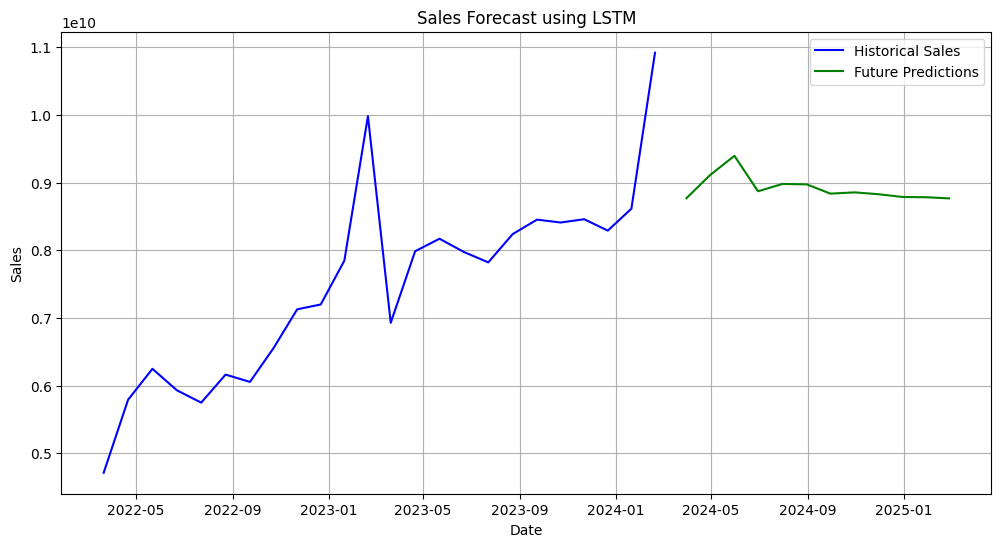

Future Predictions:
            Predicted Sales
2024-03-31     8.768841e+09
2024-04-30     9.109595e+09
2024-05-31     9.394552e+09
2024-06-30     8.870938e+09
2024-07-31     8.979170e+09
2024-08-31     8.973062e+09
2024-09-30     8.836062e+09
2024-10-31     8.854687e+09
2024-11-30     8.827443e+09
2024-12-31     8.786382e+09
2025-01-31     8.782653e+09
2025-02-28     8.765578e+09


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import jdatetime

# Create the DataFrame with Shamsi dates and sales data
data = {
    "date": [
        "1401-01", "1401-02", "1401-03", "1401-04", "1401-05",
        "1401-06", "1401-07", "1401-08", "1401-09", "1401-10",
        "1401-11", "1401-12", "1402-01", "1402-02", "1402-03",
        "1402-04", "1402-05", "1402-06", "1402-07", "1402-08",
        "1402-09", "1402-10", "1402-11", "1402-12"
    ],
    "مجموع": [
        4711607223.556961, 5789302831.537865, 6247241161.421834, 
        5930504059.921055, 5747216635.687351, 6161679873.581699,
        6053795194.559947, 6553566286.254184, 7125906639.43639,
        7198089641.705729, 7845446633.328383, 9980803600.928616,
        6927248013.418947, 7984405532.993462, 8169348417.991675,
        7973813837.050559, 7819983557.842994, 8237619201.29318,
        8451976947.99286, 8409376704.655896, 8457885204.084438,
        8289609728.094483, 8613289888.130478, 10918507216.936815
    ]
}

# Convert the dates from Shamsi to Gregorian
def convert_shamsi_to_gregorian(shamsi_date):
    year, month = map(int, shamsi_date.split('-'))
    g_date = jdatetime.date(year, month, 1).togregorian()  # Convert to Gregorian
    return g_date

# Create a DataFrame
df = pd.DataFrame(data)

# Convert Shamsi dates to Gregorian dates
df['date'] = df['date'].apply(convert_shamsi_to_gregorian)

# Set the date as the index
df.set_index('date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['مجموع'].values.reshape(-1, 1))

# Prepare the training data
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create dataset in the format LSTM expects
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create datasets
time_step =3  # Number of time steps to look back
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))




optimizer = Adam(learning_rate=0.001)  # Setting the learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')


# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# # Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Prepare the data for plotting
valid = df[['مجموع']].copy()  # Create a DataFrame to hold valid data
valid['Predictions'] = np.nan

# Add predictions to the valid DataFrame
train_data_len = len(train_data)
valid['Predictions'].iloc[train_data_len:train_data_len + len(test_predict)] = test_predict.flatten()

# Forecasting the next 12 months
last_data = scaled_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []

for _ in range(12):
    prediction = model.predict(last_data)
    future_predictions.append(prediction[0][0])
    last_data = np.append(last_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame for future predictions
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted Sales'])

# Plot the results without the valid predictions
plt.figure(figsize=(12, 6))
plt.plot(df['مجموع'], label='Historical Sales', color='blue')
plt.plot(future_df, label='Future Predictions', color='green')
plt.title('Sales Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

print("Future Predictions:")
print(future_df)



df["مجموع"].iloc[11:23]

In [64]:
future_df["Predicted Sales"]

2024-03-31    8.768841e+09
2024-04-30    9.109595e+09
2024-05-31    9.394552e+09
2024-06-30    8.870938e+09
2024-07-31    8.979170e+09
2024-08-31    8.973062e+09
2024-09-30    8.836062e+09
2024-10-31    8.854687e+09
2024-11-30    8.827443e+09
2024-12-31    8.786382e+09
2025-01-31    8.782653e+09
2025-02-28    8.765578e+09
Freq: M, Name: Predicted Sales, dtype: float32

future_df["Predicted Sales"]

In [65]:
future_df["Predicted Sales"]

2024-03-31    8.768841e+09
2024-04-30    9.109595e+09
2024-05-31    9.394552e+09
2024-06-30    8.870938e+09
2024-07-31    8.979170e+09
2024-08-31    8.973062e+09
2024-09-30    8.836062e+09
2024-10-31    8.854687e+09
2024-11-30    8.827443e+09
2024-12-31    8.786382e+09
2025-01-31    8.782653e+09
2025-02-28    8.765578e+09
Freq: M, Name: Predicted Sales, dtype: float32

In [60]:
np.sum(df["مجموع"].iloc[11:23])

99315360634.4776

In [61]:
np.sum(future_df["Predicted Sales"])

106948960000.0

In [63]:
(np.sum(future_df["Predicted Sales"]))-(np.sum(df["مجموع"].iloc[11:23]))

7633599621.5224